In [1]:
from matplotlib import pyplot
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.imputation.mice as mice
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer


%matplotlib inline

/usr/local/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


## Load Data

In [2]:
train16 = pd.read_csv("train_2016_v2.csv", parse_dates=["transactiondate"])
print(train16.shape)
train16.tail()

(90275, 3)


,parcelid,logerror,transactiondate
90270,10774160,-0.0356,2016-12-30
90271,12046695,0.0070,2016-12-30
90272,12995401,-0.2679,2016-12-30
90273,11402105,0.0602,2016-12-30
90274,12566293,0.4207,2016-12-30


In [3]:
property16 = pd.read_csv("properties_2016.csv")
print(property16.shape)
property16.tail()

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2985217, 58)


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
2985212,168176230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985213,14273630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985214,168040630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985215,168040830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985216,168040430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
train2016 = train16.set_index('parcelid').join(property16.set_index('parcelid'))
train2016["abs_logerror"] = abs(train2016["logerror"])
train2016.reset_index(inplace=True)
print(train2016.shape)
train2016.head()

(90275, 61)


,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,abs_logerror
0,10711738,0.0276,2016-08-02,1.0,NaN,NaN,3.0,4.0,NaN,4.0,...,NaN,245180.0,567112.0,2015.0,321932.0,7219.18,NaN,NaN,6.037113e+13,0.0276
1,10711755,-0.0182,2016-08-02,1.0,NaN,NaN,3.0,3.0,NaN,4.0,...,NaN,254691.0,459844.0,2015.0,205153.0,6901.09,NaN,NaN,6.037113e+13,0.0182
2,10711805,-0.1009,2016-05-03,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,235114.0,384787.0,2015.0,149673.0,4876.61,NaN,NaN,6.037113e+13,0.1009
3,10711816,-0.0121,2016-04-05,1.0,NaN,NaN,2.0,4.0,NaN,4.0,...,NaN,262309.0,437176.0,2015.0,174867.0,5560.07,NaN,NaN,6.037113e+13,0.0121
4,10711858,-0.0481,2016-07-15,1.0,NaN,NaN,2.0,4.0,NaN,4.0,...,NaN,232037.0,382055.0,2015.0,150018.0,4878.25,NaN,NaN,6.037113e+13,0.0481


## Preprocessing

## Make Test data
- train_list = ['basementsqft',
 'finishedsquarefeet13',
 'lotsizesquarefeet',
 'unitcnt',
 'bedroomcnt_log',
 'regionidzip',
 'taxvaluedollarcnt',
 'taxamount',
 'bathroomcnt_log',
 'poolsizesum',
 'yearbuilt',
 'fips']

### fill in NaN - Room, Bath, Bed
- fullbathcnt 와 bathroomcnt는 서로 비슷한 값을 가진다.
- threequarterbathnbr 최빈값인 1.0 으로 채운다.

In [5]:
train_list = ['basementsqft',
 'finishedsquarefeet13',
 'lotsizesquarefeet',
 'unitcnt',
 'bedroomcnt_log',
 'regionidzip',
 'taxvaluedollarcnt',
 'taxamount',
 'bathroomcnt_log',
 'poolsizesum',
 'yearbuilt',
 'fips']

Text(0,0.5,'bathroomcnt')

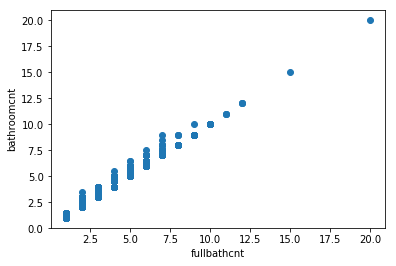

In [6]:
pyplot.scatter(train2016["fullbathcnt"], train2016["bathroomcnt"])
plt.xlabel("fullbathcnt")
plt.ylabel("bathroomcnt")

In [7]:
ls = property16[np.isnan(property16["fullbathcnt"])]["bathroomcnt"]
property16.loc[np.isnan(property16["fullbathcnt"]), "fullbathcnt"] = ls

property16[np.isnan(property16["fullbathcnt"])]

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
119159,76914755,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,1.0,NaN,299198.0,407996.0,2012.0,108798.0,NaN,NaN,NaN,NaN
148887,79639557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,12366.0,67366.0,2001.0,55000.0,780.54,NaN,NaN,NaN
163732,79639558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,6869.0,43992.0,2001.0,37123.0,541.64,NaN,NaN,NaN
267876,79639565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,98235.0,840698.0,2012.0,742463.0,NaN,NaN,NaN,NaN
371945,76915372,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,1.0,NaN,50000.0,6800000.0,2012.0,6750000.0,NaN,NaN,NaN,NaN
550411,76916784,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,...,1.0,NaN,176764.0,251421.0,2012.0,74657.0,NaN,NaN,NaN,NaN
595101,76915787,NaN,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN,...,1.0,NaN,1499400.0,4998000.0,2012.0,3498600.0,NaN,NaN,NaN,NaN
877580,76916206,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,...,1.0,NaN,1198242.0,13256758.0,2012.0,12058516.0,NaN,NaN,NaN,NaN
1457746,76914445,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,1.0,NaN,106665.0,746662.0,2012.0,639997.0,NaN,NaN,NaN,NaN
1576791,76914853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2157.0,188972.0,2010.0,186815.0,NaN,NaN,NaN,NaN


In [8]:
property16["threequarterbathnbr"].value_counts()

1.0    308959
2.0      2338
3.0       261
4.0        46
5.0        16
6.0         9
7.0         2
Name: threequarterbathnbr, dtype: int64

In [9]:
property16.loc[np.isnan(property16["threequarterbathnbr"]), "threequarterbathnbr"] = 1.0
property16[np.isnan(property16["threequarterbathnbr"])]

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock


### variable change : Log
- 독립 변수나 종속 변수가 심하게 한쪽으로 치우친 분포를 보이는 경우
- 변수 변환을 위해 log를 취한다.

In [10]:
def logg(x):
    if x == 0:
        return 0
    return np.log(x)

In [11]:
property16["roomcnt_log"] = property16["roomcnt"].apply(logg)
property16["roomcnt_log"].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: roomcnt_log, dtype: float64

In [12]:
property16["bathroomcnt_log"] = property16["bathroomcnt"].apply(logg)
property16["bathroomcnt_log"].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: bathroomcnt_log, dtype: float64

In [13]:
property16["threequarterbathnbr_log"] = property16["threequarterbathnbr"].apply(logg)
property16["threequarterbathnbr_log"].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: threequarterbathnbr_log, dtype: float64

In [14]:
property16["fullbathcnt_log"] = property16["fullbathcnt"].apply(logg)
property16["fullbathcnt_log"].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: fullbathcnt_log, dtype: float64

In [15]:
property16["bedroomcnt_log"] = property16["bedroomcnt"].apply(logg)
property16["bedroomcnt_log"].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: bedroomcnt_log, dtype: float64

### fill in NaN - airconditioningtypeid, heatingorsystemtypeid
- 각각의 최빈값인 airconditioningtypeid=1.0, heatingorsystemtypeid=2.0을 넣어준다.

In [16]:
property16.loc[np.isnan(property16["airconditioningtypeid"]), "airconditioningtypeid"] = 1.0
property16.loc[np.isnan(property16["heatingorsystemtypeid"]), "heatingorsystemtypeid"] = 2.0
property16[["airconditioningtypeid", "heatingorsystemtypeid"]].isna().sum()

airconditioningtypeid    0
heatingorsystemtypeid    0
dtype: int64

### fill in NaN - airconditioningtypeid, heatingorsystemtypeid
- fireplacecnt의 최빈값 1.0, fireplaceflag 는 들어있는 true값을 제외하고 모두 false (1/0)

In [17]:
property16["fireplaceflag"] = property16["fireplaceflag"].astype(float)

property16.loc[np.isnan(property16["fireplacecnt"]), "fireplacecnt"] = 1.0
property16.loc[np.isnan(property16["fireplaceflag"]), "fireplaceflag"] = 0.0
property16[["fireplacecnt", "fireplaceflag"]].isna().sum()

fireplacecnt     0
fireplaceflag    0
dtype: int64

In [18]:
print(property16.shape)

(2985217, 63)


## 세금과 관련된 컬럼 fill
- structuretaxvaluedollarcnt = taxvaluedollarcnt - landtaxvaluedollarcnt
- taxamount : taxamount와 taxvaluedollarcnt의 비율을 구한다음 평균값을 구해서 taxvaluedollarcnt에 곱해준 값을 채움
- taxdelinquencyflag : Y값은 1로 대체 NaN 값은 0으로 대체

In [19]:
property16.loc[np.isnan(property16["taxvaluedollarcnt"]), "taxvaluedollarcnt"] = np.mean(property16["taxvaluedollarcnt"].notnull())
property16.loc[np.isnan(property16["landtaxvaluedollarcnt"]), "landtaxvaluedollarcnt"] = np.mean(property16["landtaxvaluedollarcnt"].notnull())
property16["structuretaxvaluedollarcnt"] = property16["taxvaluedollarcnt"] - property16["landtaxvaluedollarcnt"]
property16.loc[property16["taxdelinquencyflag"] == 'Y', "taxdelinquencyflag"] = 1.0
property16.loc[property16["taxdelinquencyflag"].isnull(), "taxdelinquencyflag"] = 0.0

In [20]:
# NaN_taxamount = avg(taxamount / taxvaluedollarcnt) * taxvaluedollarcnt

In [21]:
rate = (property16[~np.isnan(property16["taxamount"])]["taxamount"] / property16[~np.isnan(property16["taxamount"])]["taxvaluedollarcnt"]).mean()

In [22]:
property16.loc[np.isnan(property16["taxamount"]), "taxamount"] = rate * property16[np.isnan(property16["taxamount"])]["taxvaluedollarcnt"]

## 층과 관련된 컬럼 Fill
- numberofstories : structuretaxvaluedollarcnt가 0이면 0, 나머지는 1.0으로 채워줌, 최빈값
- 건물세가 없고 층이 Nan값이면 0으로 채움
- 1층 면적이 있고 층이 Nan값이면 1로 채워줌

In [23]:
property16.loc[property16["numberofstories"].isnull() & property16["structuretaxvaluedollarcnt"]==0.0 ,"numberofstories"] = 0.0
property16.loc[(property16["numberofstories"] == 0.0) & property16["finishedfloor1squarefeet"].notnull(), "numberofstories"] = 1.0
property16["numberofstories"].fillna(value = 1.0, inplace = True)
#storytypeid: 0으로 채워줌(유무)
property16["storytypeid"].fillna(value = 0, inplace = True)
property16["basementsqft"].fillna(value = 0, inplace = True)

## 면적과 관련된 컬럼 fill

In [24]:
# 총면적이 1층 면적보다 작은경우 1층 면적을 총면적에 대입
property16.loc[property16["calculatedfinishedsquarefeet"].notnull() < property16["finishedsquarefeet50"].notnull(), "calculatedfinishedsquarefeet"] = property16["finishedsquarefeet50"]
# 층수가 없는 경우 총면적의 NaN은 0
property16.loc[(property16["numberofstories"] == 0.0) & property16["calculatedfinishedsquarefeet"].isnull(), "calculatedfinishedsquarefeet"] = 0.0
# 건물이 있지만 총면적이 0인 경우 총면적의 평균을 대입
property16.loc[(property16["numberofstories"] != 0.0) & property16["calculatedfinishedsquarefeet"].isnull(),"calculatedfinishedsquarefeet"] = np.mean(property16["calculatedfinishedsquarefeet"].notnull())

In [25]:
# 1층의 면적을 나타내는 finishedfloor1squarefeet, finishedsquarefeet50의 Nan값은 calculatedfinishedsquarefeet의 값으로 대체(대부분 비슷하지만 조금 차이가남)
property16.loc[property16["finishedfloor1squarefeet"].isnull(), "finishedfloor1squarefeet"] = property16.loc[property16["finishedfloor1squarefeet"].isnull(),"calculatedfinishedsquarefeet"]
property16.loc[property16["finishedsquarefeet50"].isnull(), "finishedsquarefeet50"] = property16.loc[property16["finishedsquarefeet50"].isnull() ,"calculatedfinishedsquarefeet"]
property16.loc[property16["finishedsquarefeet6"].isnull(), "finishedsquarefeet6"] = property16.loc[property16["finishedsquarefeet6"].isnull(), "calculatedfinishedsquarefeet"]

In [26]:
# 총면적과 거주 공간외 공간의 면적이 같은 경우 거주 공간의 면적을 0으로 넣어줌
property16.loc[property16["calculatedfinishedsquarefeet"].notnull() == property16["finishedsquarefeet13"].notnull(), "finishedsquarefeet12"] = 0.0
# finishedsquarefeet12의 NaN값은 calculatedfinishedsquarefeet와 일치 
property16.loc[property16["finishedsquarefeet12"].isnull(), "finishedsquarefeet12"] = property16.loc[property16["finishedsquarefeet12"].isnull(), "calculatedfinishedsquarefeet"]
property16["finishedsquarefeet13"].fillna(value = 0.0, inplace=True)
# finishedsquarefeet15 : calculatedfinishedsquarefeet의 값으로 채워줌
property16.loc[property16["finishedsquarefeet15"].isnull(), "finishedsquarefeet15"] = property16.loc[property16["finishedsquarefeet15"].isnull(), "calculatedfinishedsquarefeet"]
# lotsizesquarefeet의 값이  finishedsquarefeet50(1층면적) 보다 작은 경우 1층면적으로 대체
property16.loc[property16["finishedsquarefeet50"] > property16["lotsizesquarefeet"], "lotsizesquarefeet"] = property16.loc[property16["finishedsquarefeet50"] > property16["lotsizesquarefeet"] ,"finishedsquarefeet50"]
# calculatedfinishedsquarefeet(총면적)이 있는데 lotsizesquarefeet이 NaN인 경우 1층의 값으로 대입
property16.loc[property16["lotsizesquarefeet"].isnull() & property16["calculatedfinishedsquarefeet"].notnull(), "lotsizesquarefeet"] = property16.loc[property16["lotsizesquarefeet"].isnull(), "finishedsquarefeet50"]

property16.loc[property16["yearbuilt"].isnull() & property16["buildingqualitytypeid"] == 7.0, "yearbuilt"] = 1950
property16.loc[property16["yearbuilt"].isnull() & property16["buildingqualitytypeid"] == 4.0, "yearbuilt"] = 1979
property16["yearbuilt"].fillna(value = 1955, inplace = True)

property16.loc[property16["unitcnt"].isnull() & (property16["calculatedfinishedsquarefeet"] == 0), "unitcnt"] = 0
property16["unitcnt"].fillna(value = 1, inplace = True)

## 건설 시기, 건물 구조물 등 컬럼 fill

In [27]:
property16["decktypeid"].fillna(value = 0.0, inplace = True)
property16.loc[property16["decktypeid"] == 66.0 , "decktypeid"] = 1
property16.loc[property16["buildingqualitytypeid"].isnull() & (property16["structuretaxvaluedollarcnt"] == 0), "buildingqualitytypeid"]=0
property16.loc[property16["buildingqualitytypeid"].isnull(), "buildingqualitytypeid"] = property16["buildingqualitytypeid"].mode()[0]
property16.loc[property16["buildingclasstypeid"].notnull(), "buildingclasstypeid"] = 1
property16.loc[property16["buildingclasstypeid"].isnull(), "buildingclasstypeid"] = 0
property16["architecturalstyletypeid"].fillna(value=7, inplace=True)
property16['typeconstructiontypeid'].fillna(value=6, inplace=True)

In [28]:
print(property16.shape)

(2985217, 63)


## yardbuildingsqft17, garagecarcnt, garagetotalsqft : fill in NaN

In [29]:
property16.loc[property16.yardbuildingsqft17.isnull(), 'yardbuildingsqft17'] = 0.0
property16[['garagecarcnt', 'garagetotalsqft']][(property16.garagetotalsqft != 0) & (property16.garagecarcnt == 0)]
property16.loc[17269025, 'garagecarcnt'] = 1.0
property16.loc[np.isnan(property16["garagecarcnt"]), "garagecarcnt"] = 0.0
property16.loc[np.isnan(property16["garagecarcnt"])]

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,roomcnt_log,bathroomcnt_log,threequarterbathnbr_log,fullbathcnt_log,bedroomcnt_log


In [30]:
prop_garages =  ['garagecarcnt', 'garagetotalsqft']
mean_garagesqft = property16[prop_garages].groupby(['garagecarcnt']).agg('mean')

In [31]:
def garagesqft_fillna(garagecarcnt):
    x = round(mean_garagesqft.loc[garagecarcnt][0], 0)
    #print(x)
    property16.loc[(property16.garagecarcnt == garagecarcnt) & (property16.garagetotalsqft == 0),'garagetotalsqft'] = x

In [32]:
for i in mean_garagesqft.index[1:] :
    garagesqft_fillna(i)

## Fill NaN : poolcnt, pooltypeid2, pooltypeid7, pooltypeid10, yardbuildingsqft26

In [33]:
property16["garagecarcnt"].fillna(value=0, inplace=True)
property16["garagetotalsqft"].fillna(value=0, inplace=True)
property16["poolcnt"].fillna(value=0.0, inplace=True)
property16['pooltypeid2'].fillna(value=0, inplace=True)
property16['pooltypeid7'].fillna(value=0, inplace=True)
property16['pooltypeid10'].fillna(value=0, inplace=True)
property16["yardbuildingsqft26"].fillna(value=1, inplace=True)

## Fill NaN : regionidzip

In [34]:
property16.loc[np.isnan(property16["regionidzip"]) & (property16["fips"] == 6059.0), "regionidzip"] = 96987.0
property16.loc[np.isnan(property16["regionidzip"]) & (property16["fips"] == 6111.0), "regionidzip"] = 97118.0
property16.loc[np.isnan(property16["regionidzip"]) & (property16["fips"] == 6037.0), "regionidzip"] = 96193.0

In [35]:
print(property16.shape)

(2985218, 63)


## Fill NaN : poolsizesum

In [36]:
property16["poolsizesum"].mode()[0]

450.0

In [37]:
property16.loc[property16["poolcnt"] == 1, "poolsizesum"] = property16["poolsizesum"].mode()[0]
property16.loc[property16["poolcnt"] == 0, "poolsizesum"] = 0.0

In [38]:
property16.loc[np.isnan(property16["bedroomcnt_log"]), "bedroomcnt_log"] = property16["bedroomcnt_log"].mode()[0]
property16.loc[np.isnan(property16["bathroomcnt_log"]), "bathroomcnt_log"] = property16["bathroomcnt_log"].mode()[0]

#property16["bathroomcnt_log"]

In [39]:
property16.loc[np.isnan(property16["fips"]), "fips"] = property16["fips"].mode()[0]
property16.loc[np.isnan(property16["regionidzip"]), "regionidzip"] = property16["regionidzip"].mode()[0]

In [40]:
print(property16.shape)

(2985218, 63)


In [41]:
property16[train_list].isna().sum()

basementsqft            1
finishedsquarefeet13    1
lotsizesquarefeet       1
unitcnt                 1
bedroomcnt_log          0
regionidzip             0
taxvaluedollarcnt       1
taxamount               1
bathroomcnt_log         0
poolsizesum             0
yearbuilt               1
fips                    0
dtype: int64

In [42]:
property16 = property16[train_list][:2985217]
property16[train_list][:2985217].tail()

,basementsqft,finishedsquarefeet13,lotsizesquarefeet,unitcnt,bedroomcnt_log,regionidzip,taxvaluedollarcnt,taxamount,bathroomcnt_log,poolsizesum,yearbuilt,fips
2985212,0.0,0.0,0.984309,1.0,1.098612,96193.0,0.985746,2.784516,0.693147,0.0,1955.0,6037.0
2985213,0.0,0.0,0.984309,1.0,1.098612,96193.0,0.985746,2.784516,0.693147,0.0,1955.0,6037.0
2985214,0.0,0.0,0.984309,1.0,1.098612,96193.0,0.985746,2.784516,0.693147,0.0,1955.0,6037.0
2985215,0.0,0.0,0.984309,1.0,1.098612,96193.0,0.985746,2.784516,0.693147,0.0,1955.0,6037.0
2985216,0.0,0.0,0.984309,1.0,1.098612,96193.0,0.985746,2.784516,0.693147,0.0,1955.0,6037.0


In [43]:
property16.isna().sum()

basementsqft            0
finishedsquarefeet13    0
lotsizesquarefeet       0
unitcnt                 0
bedroomcnt_log          0
regionidzip             0
taxvaluedollarcnt       0
taxamount               0
bathroomcnt_log         0
poolsizesum             0
yearbuilt               0
fips                    0
dtype: int64

## Make train data

In [44]:
ls = train2016[np.isnan(train2016["fullbathcnt"])]["bathroomcnt"]
train2016.loc[np.isnan(train2016["fullbathcnt"]), "fullbathcnt"] = ls

train2016[np.isnan(train2016["fullbathcnt"])]

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,abs_logerror


In [45]:
train2016.loc[np.isnan(train2016["threequarterbathnbr"]), "threequarterbathnbr"] = 1.0
train2016[np.isnan(train2016["threequarterbathnbr"])]

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,abs_logerror


In [46]:
def logg(x):
    if x == 0:
        return 0
    return np.log(x)

In [47]:
train2016["roomcnt_log"] = train2016["roomcnt"].apply(logg)
train2016["roomcnt_log"].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: roomcnt_log, dtype: float64

In [48]:
train2016["bathroomcnt_log"] = train2016["bathroomcnt"].apply(logg)
train2016["bathroomcnt_log"].head()

0    1.098612
1    1.098612
2    0.693147
3    0.693147
4    0.693147
Name: bathroomcnt_log, dtype: float64

In [49]:
train2016["threequarterbathnbr_log"] = train2016["threequarterbathnbr"].apply(logg)
train2016["threequarterbathnbr_log"].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: threequarterbathnbr_log, dtype: float64

In [50]:
train2016["fullbathcnt_log"] = train2016["fullbathcnt"].apply(logg)
train2016["fullbathcnt_log"].head()

0    1.098612
1    1.098612
2    0.693147
3    0.693147
4    0.693147
Name: fullbathcnt_log, dtype: float64

In [51]:
train2016["bedroomcnt_log"] = train2016["bedroomcnt"].apply(logg)
train2016["bedroomcnt_log"].head()

0    1.386294
1    1.098612
2    1.098612
3    1.386294
4    1.386294
Name: bedroomcnt_log, dtype: float64

In [52]:
train2016.loc[np.isnan(train2016["airconditioningtypeid"]), "airconditioningtypeid"] = 1.0
train2016.loc[np.isnan(train2016["heatingorsystemtypeid"]), "heatingorsystemtypeid"] = 2.0
train2016[["airconditioningtypeid", "heatingorsystemtypeid"]].isna().sum()

airconditioningtypeid    0
heatingorsystemtypeid    0
dtype: int64

In [53]:
train2016["fireplaceflag"] = train2016["fireplaceflag"].astype(float)

train2016.loc[np.isnan(train2016["fireplacecnt"]), "fireplacecnt"] = 1.0
train2016.loc[np.isnan(train2016["fireplaceflag"]), "fireplaceflag"] = 0.0
train2016[["fireplacecnt", "fireplaceflag"]].isna().sum()

fireplacecnt     0
fireplaceflag    0
dtype: int64

In [54]:
train2016.loc[np.isnan(train2016["taxvaluedollarcnt"]), "taxvaluedollarcnt"] = np.mean(train2016["taxvaluedollarcnt"].notnull())
train2016.loc[np.isnan(train2016["landtaxvaluedollarcnt"]), "landtaxvaluedollarcnt"] = np.mean(train2016["landtaxvaluedollarcnt"].notnull())
train2016["structuretaxvaluedollarcnt"] = train2016["taxvaluedollarcnt"] - train2016["landtaxvaluedollarcnt"]
train2016.loc[train2016["taxdelinquencyflag"] == 'Y', "taxdelinquencyflag"] = 1.0
train2016.loc[train2016["taxdelinquencyflag"].isnull(), "taxdelinquencyflag"] = 0.0

In [55]:
rate = (train2016[~np.isnan(train2016["taxamount"])]["taxamount"] / train2016[~np.isnan(train2016["taxamount"])]["taxvaluedollarcnt"]).mean()

In [56]:
train2016.loc[np.isnan(train2016["taxamount"]), "taxamount"] = rate * train2016[np.isnan(train2016["taxamount"])]["taxvaluedollarcnt"]

In [57]:
train2016.loc[train2016["numberofstories"].isnull() & train2016["structuretaxvaluedollarcnt"]==0.0 ,"numberofstories"] = 0.0
train2016.loc[(train2016["numberofstories"] == 0.0) & train2016["finishedfloor1squarefeet"].notnull(), "numberofstories"] = 1.0
train2016["numberofstories"].fillna(value = 1.0, inplace = True)
#storytypeid: 0으로 채워줌(유무)
train2016["storytypeid"].fillna(value = 0, inplace = True)
train2016["basementsqft"].fillna(value = 0, inplace = True)

In [58]:
# 총면적이 1층 면적보다 작은경우 1층 면적을 총면적에 대입
train2016.loc[train2016["calculatedfinishedsquarefeet"].notnull() < train2016["finishedsquarefeet50"].notnull(), "calculatedfinishedsquarefeet"] = train2016["finishedsquarefeet50"]
# 층수가 없는 경우 총면적의 NaN은 0
train2016.loc[(train2016["numberofstories"] == 0.0) & train2016["calculatedfinishedsquarefeet"].isnull(), "calculatedfinishedsquarefeet"] = 0.0
# 건물이 있지만 총면적이 0인 경우 총면적의 평균을 대입
train2016.loc[(train2016["numberofstories"] != 0.0) & train2016["calculatedfinishedsquarefeet"].isnull(),"calculatedfinishedsquarefeet"] = np.mean(train2016["calculatedfinishedsquarefeet"].notnull())

In [59]:
# 1층의 면적을 나타내는 finishedfloor1squarefeet, finishedsquarefeet50의 Nan값은 calculatedfinishedsquarefeet의 값으로 대체(대부분 비슷하지만 조금 차이가남)
train2016.loc[train2016["finishedfloor1squarefeet"].isnull(), "finishedfloor1squarefeet"] = train2016.loc[train2016["finishedfloor1squarefeet"].isnull(),"calculatedfinishedsquarefeet"]
train2016.loc[train2016["finishedsquarefeet50"].isnull(), "finishedsquarefeet50"] = train2016.loc[train2016["finishedsquarefeet50"].isnull() ,"calculatedfinishedsquarefeet"]
train2016.loc[train2016["finishedsquarefeet6"].isnull(), "finishedsquarefeet6"] = train2016.loc[train2016["finishedsquarefeet6"].isnull(), "calculatedfinishedsquarefeet"]

In [60]:
# 총면적과 거주 공간외 공간의 면적이 같은 경우 거주 공간의 면적을 0으로 넣어줌
train2016.loc[train2016["calculatedfinishedsquarefeet"].notnull() == train2016["finishedsquarefeet13"].notnull(), "finishedsquarefeet12"] = 0.0
# finishedsquarefeet12의 NaN값은 calculatedfinishedsquarefeet와 일치 
train2016.loc[train2016["finishedsquarefeet12"].isnull(), "finishedsquarefeet12"] = train2016.loc[train2016["finishedsquarefeet12"].isnull(), "calculatedfinishedsquarefeet"]
train2016["finishedsquarefeet13"].fillna(value = 0.0, inplace=True)
# finishedsquarefeet15 : calculatedfinishedsquarefeet의 값으로 채워줌
train2016.loc[train2016["finishedsquarefeet15"].isnull(), "finishedsquarefeet15"] = train2016.loc[train2016["finishedsquarefeet15"].isnull(), "calculatedfinishedsquarefeet"]
# lotsizesquarefeet의 값이  finishedsquarefeet50(1층면적) 보다 작은 경우 1층면적으로 대체
train2016.loc[train2016["finishedsquarefeet50"] > train2016["lotsizesquarefeet"], "lotsizesquarefeet"] = train2016.loc[train2016["finishedsquarefeet50"] > train2016["lotsizesquarefeet"] ,"finishedsquarefeet50"]
# calculatedfinishedsquarefeet(총면적)이 있는데 lotsizesquarefeet이 NaN인 경우 1층의 값으로 대입
train2016.loc[train2016["lotsizesquarefeet"].isnull() & train2016["calculatedfinishedsquarefeet"].notnull(), "lotsizesquarefeet"] = train2016.loc[train2016["lotsizesquarefeet"].isnull(), "finishedsquarefeet50"]

train2016.loc[train2016["yearbuilt"].isnull() & train2016["buildingqualitytypeid"] == 7.0, "yearbuilt"] = 1950
train2016.loc[train2016["yearbuilt"].isnull() & train2016["buildingqualitytypeid"] == 4.0, "yearbuilt"] = 1979
train2016["yearbuilt"].fillna(value = 1955, inplace = True)

train2016.loc[train2016["unitcnt"].isnull() & (train2016["calculatedfinishedsquarefeet"] == 0), "unitcnt"] = 0
train2016["unitcnt"].fillna(value = 1, inplace = True)

In [61]:
train2016["decktypeid"].fillna(value = 0.0, inplace = True)
train2016.loc[train2016["decktypeid"] == 66.0 , "decktypeid"] = 1
train2016.loc[train2016["buildingqualitytypeid"].isnull() & (train2016["structuretaxvaluedollarcnt"] == 0), "buildingqualitytypeid"]=0
train2016.loc[train2016["buildingqualitytypeid"].isnull(), "buildingqualitytypeid"] = train2016["buildingqualitytypeid"].mode()[0]
train2016.loc[train2016["buildingclasstypeid"].notnull(), "buildingclasstypeid"] = 1
train2016.loc[train2016["buildingclasstypeid"].isnull(), "buildingclasstypeid"] = 0
train2016["architecturalstyletypeid"].fillna(value=7, inplace=True)
train2016['typeconstructiontypeid'].fillna(value=6, inplace=True)

In [62]:
train2016.loc[train2016.yardbuildingsqft17.isnull(), 'yardbuildingsqft17'] = 0.0
train2016[['garagecarcnt', 'garagetotalsqft']][(train2016.garagetotalsqft != 0) & (train2016.garagecarcnt == 0)]
train2016.loc[17269025, 'garagecarcnt'] = 1.0
train2016.loc[np.isnan(train2016["garagecarcnt"]), "garagecarcnt"] = 0.0
train2016.loc[np.isnan(train2016["garagecarcnt"])]

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,abs_logerror,roomcnt_log,bathroomcnt_log,threequarterbathnbr_log,fullbathcnt_log,bedroomcnt_log


In [63]:
prop_garages =  ['garagecarcnt', 'garagetotalsqft']
mean_garagesqft = train2016[prop_garages].groupby(['garagecarcnt']).agg('mean')

In [64]:
def garagesqft_fillna(garagecarcnt):
    x = round(mean_garagesqft.loc[garagecarcnt][0], 0)
    #print(x)
    train2016.loc[(train2016.garagecarcnt == garagecarcnt) & (train2016.garagetotalsqft == 0),'garagetotalsqft'] = x

In [65]:
for i in mean_garagesqft.index[1:] :
    garagesqft_fillna(i)

In [66]:
train2016["garagecarcnt"].fillna(value=0, inplace=True)
train2016["garagetotalsqft"].fillna(value=0, inplace=True)
train2016["poolcnt"].fillna(value=0.0, inplace=True)
train2016['pooltypeid2'].fillna(value=0, inplace=True)
train2016['pooltypeid7'].fillna(value=0, inplace=True)
train2016['pooltypeid10'].fillna(value=0, inplace=True)
train2016["yardbuildingsqft26"].fillna(value=1, inplace=True)

In [67]:
model_poolsizesum = sm.OLS.from_formula("poolsizesum~I(finishedsquarefeet50*0.01)+I(garagetotalsqft*0.01)+C(poolcnt)+0", data = train2016)
poolsizesum_result = model_poolsizesum.fit()
predicted_poolsizesum = poolsizesum_result.predict(train2016[['poolcnt','finishedsquarefeet50', 'garagetotalsqft']].dropna())

In [68]:
for i in predicted_poolsizesum.index :
    if train2016.loc[i, 'poolcnt'] > 0 & np.isnan(train2016.loc[i, "poolsizesum"]):
        train2016.loc[i, 'poolsizesum'] = round(predicted_poolsizesum.loc(0)[i], 0)
    else:
        pass
train2016.loc[train2016["poolsizesum"].isnull() & (train2016["poolcnt"]==0), "poolsizesum"] = 0
for_mean = train2016[train2016["poolcnt"]==1]["poolsizesum"]
train2016.loc[(train2016["poolcnt"] == 1) & train2016["poolsizesum"].isnull(), "poolsizesum"] = for_mean.dropna().mean()
train2016["yardbuildingsqft26"].fillna(value=1, inplace=True)

In [69]:
train2016.loc[np.isnan(train2016["regionidzip"]) & (train2016["fips"] == 6059.0), "regionidzip"] = 96987.0
train2016.loc[np.isnan(train2016["regionidzip"]) & (train2016["fips"] == 6111.0), "regionidzip"] = 97118.0

In [70]:
train_list = ["basementsqft","finishedsquarefeet13","lotsizesquarefeet","unitcnt","bedroomcnt_log","regionidzip","taxvaluedollarcnt","taxamount","bathroomcnt_log","poolsizesum","yearbuilt","fips"]

In [71]:
train2016[train_list].isna().sum()

basementsqft            1
finishedsquarefeet13    1
lotsizesquarefeet       1
unitcnt                 1
bedroomcnt_log          1
regionidzip             1
taxvaluedollarcnt       1
taxamount               1
bathroomcnt_log         1
poolsizesum             0
yearbuilt               1
fips                    1
dtype: int64

In [72]:
train2016 = train2016[:90275]
train2016.tail()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,abs_logerror,roomcnt_log,bathroomcnt_log,threequarterbathnbr_log,fullbathcnt_log,bedroomcnt_log
90270,162960704.0,-0.0151,2016-07-19,1.0,7.0,0.0,2.5,4.0,0.0,7.0,...,6314.44,0.0,NaN,6.111006e+13,0.0151,2.079442,0.916291,0.0,0.693147,1.386294
90271,162960769.0,-0.0171,2016-06-06,1.0,7.0,0.0,2.0,4.0,0.0,7.0,...,2853.08,0.0,NaN,6.111006e+13,0.0171,2.079442,0.693147,0.0,0.693147,1.386294
90272,162960801.0,-0.0050,2016-10-12,1.0,7.0,0.0,2.0,4.0,0.0,7.0,...,2345.04,0.0,NaN,6.111008e+13,0.0050,2.079442,0.693147,0.0,0.693147,1.386294
90273,162960829.0,-0.0704,2016-04-08,1.0,7.0,0.0,2.0,3.0,0.0,7.0,...,3248.82,0.0,NaN,NaN,0.0704,1.791759,0.693147,0.0,0.693147,1.098612
90274,162960842.0,-0.0545,2016-06-10,1.0,7.0,0.0,2.5,4.0,0.0,7.0,...,7542.12,0.0,NaN,6.111006e+13,0.0545,1.945910,0.916291,0.0,0.693147,1.386294


In [73]:
train2016[train_list].isna().sum() 

basementsqft            0
finishedsquarefeet13    0
lotsizesquarefeet       0
unitcnt                 0
bedroomcnt_log          0
regionidzip             0
taxvaluedollarcnt       0
taxamount               0
bathroomcnt_log         0
poolsizesum             0
yearbuilt               0
fips                    0
dtype: int64

In [74]:
model = sm.OLS.from_formula("logerror ~ scale(basementsqft) +\
    scale(finishedsquarefeet13) +\
    scale(lotsizesquarefeet) +\
    scale(unitcnt) +\
    scale(bedroomcnt_log) +\
    scale(regionidzip) +\
    scale(taxvaluedollarcnt) +\
    scale(taxamount) +\
    scale(bathroomcnt_log) +\
    scale(poolsizesum) +\
    scale(yearbuilt) +\
    C(fips) + 0", data=train2016)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               logerror   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     20.86
Date:                Fri, 06 Jul 2018   Prob (F-statistic):           2.94e-50
Time:                        19:15:45   Log-Likelihood:                 36871.
No. Observations:               90275   AIC:                        -7.371e+04
Df Residuals:                   90261   BIC:                        -7.358e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
C(fips)[6037.0]   

In [75]:
y_hat = result.predict(property16)

In [76]:
print(len(y_hat))
y_hat.head()

2985217


0    0.004581
1   -0.240191
2   -0.011215
3   -0.001029
4    0.000211
dtype: float64

In [77]:
submission = pd.read_csv("sample_submission.csv")

In [78]:
submission["201610"] = y_hat
submission["201611"] = y_hat
submission["201612"] = y_hat
submission["201710"] = y_hat
submission["201711"] = y_hat
submission["201712"] = y_hat

submission.head()

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0.004581,0.004581,0.004581,0.004581,0.004581,0.004581
1,10759547,-0.240191,-0.240191,-0.240191,-0.240191,-0.240191,-0.240191
2,10843547,-0.011215,-0.011215,-0.011215,-0.011215,-0.011215,-0.011215
3,10859147,-0.001029,-0.001029,-0.001029,-0.001029,-0.001029,-0.001029
4,10879947,0.000211,0.000211,0.000211,0.000211,0.000211,0.000211


In [79]:
submission.to_csv("test.csv", index=False)